In [22]:
import pandas as pd
from lightgbm import LGBMRegressor
import violation_common
from sklearn.metrics import r2_score
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [8]:
data_train = pd.read_csv('data/after_2010_train_full.csv')
data_validate = pd.read_csv('data/after_2010_test.csv')

In [3]:
categorical_cols = ['PRIMARY_OR_MILL', 'COAL_METAL_IND', 'MINE_TYPE', 'VIOLATOR_TYPE_CD']
numerical_cols = ['VIOLATOR_INSPECTION_DAY_CNT', 'VIOLATOR_VIOLATION_CNT', 'YEAR_OCCUR']

target = 'PROPOSED_PENALTY'

In [6]:
# lightgbm params
param = {
    "objective": "regression",
    "metric": "mse",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "lambda_l1": 1.2982e-8,
    "lambda_l2": 9.3449,
    "num_leaves": 253,
    "feature_fraction": 0.5440,
    "bagging_fraction": 0.9997,
    "bagging_freq": 2,
    "min_child_samples": 30
}



In [9]:
X_train, y_train, preprocessor = violation_common.df_to_model_ready(data_train, categorical_cols, numerical_cols, target)
X_validate, y_validate, _ = violation_common.df_to_model_ready(data_validate, categorical_cols, numerical_cols, target, preprocessor=preprocessor)

In [18]:
model = LGBMRegressor(**param)
model.fit(X_train, y_train)
preds = model.predict(X_validate)
r2_train = r2_score(y_train, model.predict(X_train))
r2_test = r2_score(y_validate, preds)
clear_output()
print(f'Train R2 Score Baseline: {r2_train}')
print(f'Test R2 Score Baseline: {r2_test}')

Train R2 Score Baseline: 0.08849457815054085
Test R2 Score Baseline: 0.05893885811051314


In [19]:
# Assume only SIG_SUB == 'Y'
data_train = data_train[data_train['SIG_SUB'] == 'Y']
data_validate = data_validate[data_validate['SIG_SUB'] == 'Y']
X_train, y_train, preprocessor = violation_common.df_to_model_ready(data_train, categorical_cols, numerical_cols, target)
X_validate, y_validate, _ = violation_common.df_to_model_ready(data_validate, categorical_cols, numerical_cols, target, preprocessor=preprocessor)

model = LGBMRegressor(**param)
model.fit(X_train, y_train)
preds = model.predict(X_validate)
r2_train = r2_score(y_train, model.predict(X_train))
r2_test = r2_score(y_validate, preds)
clear_output()
print(f'Train R2 Score SIG_SUB == \'Y\': {r2_train}')
print(f'Test R2 Score SIG_SUB == \'Y\': {r2_test}')

Train R2 Score SIG_SUB == 'Y': 0.17478845052613834
Test R2 Score SIG_SUB == 'Y': 0.11296627555298944


In [21]:
# Assume only certain mine types
mine_types = data_train['MINE_TYPE'].unique()
r2_tests = {}
r2_trains = {}
for mine_type in mine_types:
    data_train_mine_type = data_train[data_train['MINE_TYPE'] == mine_type]
    data_validate_mine_type = data_validate[data_validate['MINE_TYPE'] == mine_type]
    X_train, y_train, preprocessor = violation_common.df_to_model_ready(data_train_mine_type, categorical_cols, numerical_cols, target)
    X_validate, y_validate, _ = violation_common.df_to_model_ready(data_validate_mine_type, categorical_cols, numerical_cols, target, preprocessor=preprocessor)

    model = LGBMRegressor(**param)
    model.fit(X_train, y_train)
    preds = model.predict(X_validate)
    r2_train = r2_score(y_train, model.predict(X_train))
    r2_test = r2_score(y_validate, preds)
    r2_trains[mine_type] = r2_train
    r2_tests[mine_type] = r2_test
clear_output()
print('Train R2 Score by Mine Type')
print(r2_trains)
print('Test R2 Score by Mine Type')
print(r2_tests)

Train R2 Score by Mine Type
{'Underground': 0.1855128234149983, 'Surface': 0.20489387682610716, 'Facility': 0.2864133832186523}
Test R2 Score by Mine Type
{'Underground': 0.10849460616320439, 'Surface': 0.11710778365850316, 'Facility': 0.17845168458063032}


<Axes: xlabel='MINE_TYPE'>

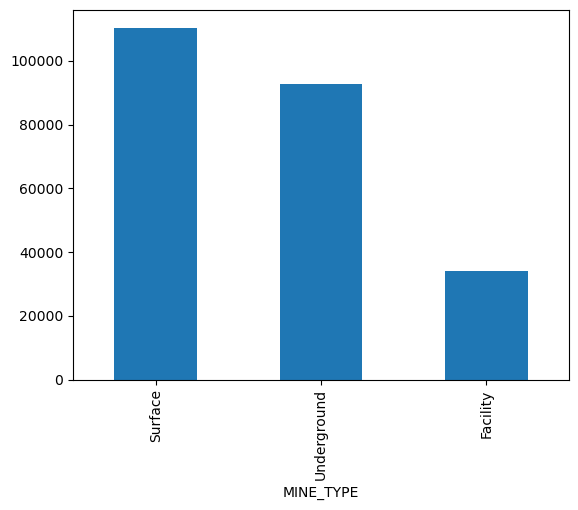

In [25]:
# plots of mine type counts
data_train['MINE_TYPE'].value_counts().plot(kind='bar')

/tmp/ipykernel_406950/3045270722.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_train[data_train['MINE_TYPE'] == mine_type][data_train['PROPOSED_PENALTY'] > 10000]['PROPOSED_PENALTY'].plot(kind='hist', ax=axes[i//3 + 1, i%3], title=f'{mine_type} > 10,000')
/tmp/ipykernel_406950/3045270722.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_train[data_train['MINE_TYPE'] == mine_type][data_train['PROPOSED_PENALTY'] > 10000]['PROPOSED_PENALTY'].plot(kind='hist', ax=axes[i//3 + 1, i%3], title=f'{mine_type} > 10,000')
/tmp/ipykernel_406950/3045270722.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_train[data_train['MINE_TYPE'] == mine_type][data_train['PROPOSED_PENALTY'] > 10000]['PROPOSED_PENALTY'].plot(kind='hist', ax=axes[i//3 + 1, i%3], title=f'{mine_type} > 10,000')


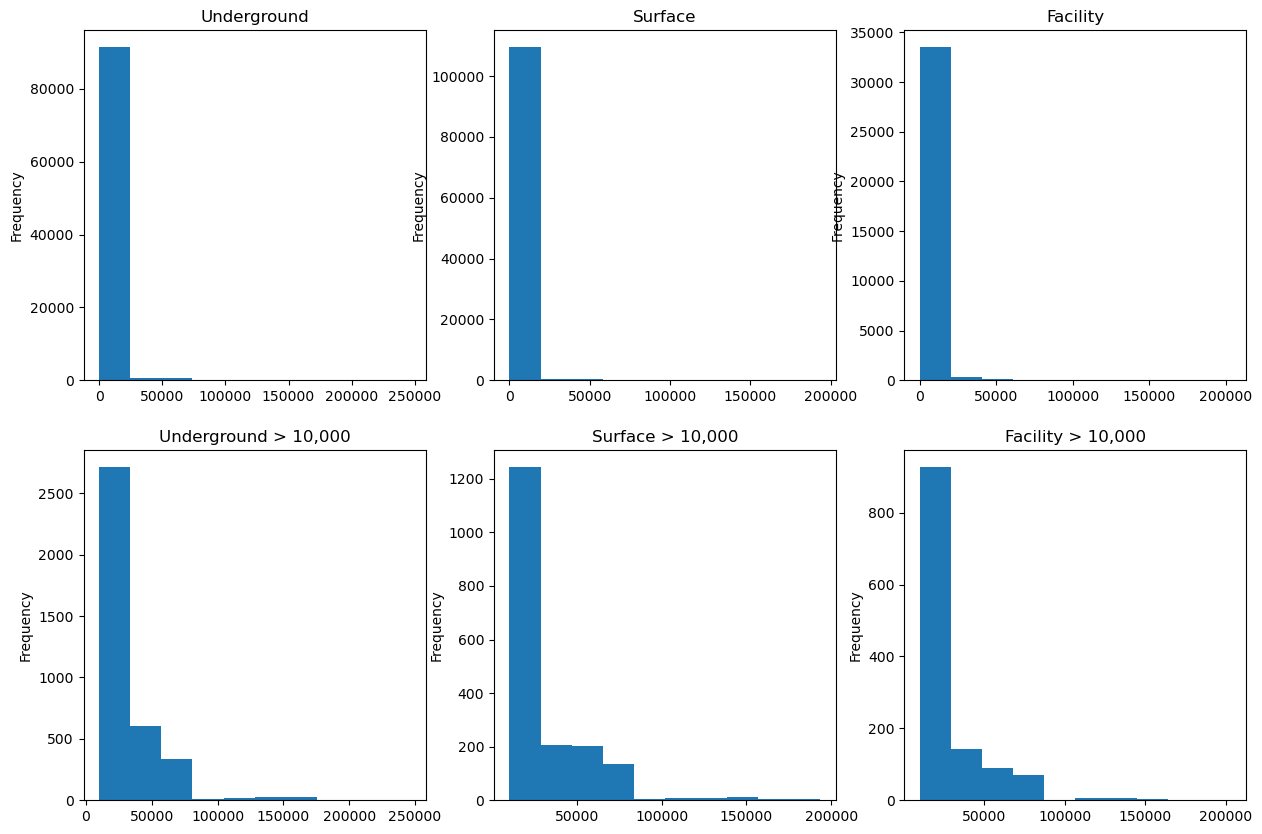

In [32]:
# PROPOSED_PENALTY histograms by mine type side by side
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, mine_type in enumerate(mine_types):
    data_train[data_train['MINE_TYPE'] == mine_type]['PROPOSED_PENALTY'].plot(kind='hist', ax=axes[i//3, i%3], title=mine_type)
    # plot hist of only > 10,000 PROPOSED_PENALTY under previous histogram
    data_train[data_train['MINE_TYPE'] == mine_type][data_train['PROPOSED_PENALTY'] > 10000]['PROPOSED_PENALTY'].plot(kind='hist', ax=axes[i//3 + 1, i%3], title=f'{mine_type} > 10,000')
